# Pokemon Legendary analysis

This notebook will analyze the full pokemon dataset scrapped from serebii.net and available on [kaggle](https://www.kaggle.com/datasets/rounakbanik/pokemon). This dataset contains all information on each pokemon, the goal being to predict whether a given pokemon is legendary.

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import scipy.stats as stats
import seaborn as sns

# We use the [pokemon web scraper](https://github.com/shadforth/pokemon-web-scraper) module to scrape missing data.
from pokemonwebscraper import scraper

In [2]:
# We load the dataset
pokemon_df = pd.read_csv("./data/pokemon.csv")

y = pokemon_df["is_legendary"]
X_full = pokemon_df.drop("is_legendary", axis=1)

Baseline probability -- what are the odds of guessing that a Pokemon is legendary by randomly choosing.

In [56]:
baseline_probability = pokemon_df["is_legendary"].sum() / pokemon_df["is_legendary"].count()
baseline_probability

0.08739076154806492

# Data cleanup

### Missing features

There are four features with missing values, let us analyze what that is the case and how much is missing.

In [57]:
scraper.extract_statistics(19)

{'name': 'Rattata',
 'number': '#019',
 'classification': 'Mouse Pokémon',
 'height': ['1\'00"', '0.3m'],
 'weight': ['7.7lbs', '3.5kg'],
 'hit_points': 30,
 'attack': 56,
 'defense': 35,
 'special': 25,
 'speed': 35}

In [58]:
columns_with_missing_entries = X_full.isnull().sum() > 0
columns_with_missing_entries_names = columns_with_missing_entries[columns_with_missing_entries].index
columns_with_missing_entries_names

Index(['height_m', 'percentage_male', 'type2', 'weight_kg'], dtype='object')

In [59]:
percentage_column_missing = {
    col: X_full[col].isnull().sum() / X_full[col].count() for col in columns_with_missing_entries_names
}
percentage_column_missing

{'height_m': 0.02560819462227913,
 'percentage_male': 0.13940256045519203,
 'type2': 0.920863309352518,
 'weight_kg': 0.02560819462227913}

The height and weights missing entries are the same. We scrape those missing values on the serebii website.

In [60]:
ids_missing_height_weight = X_full.loc[X_full["height_m"].isnull(), "pokedex_number"].values


def fix_height_weight_pokemon(df, id):
    print(id)
    dex = "swsh"
    if id == 720:
        dex = "xy"
    data = scraper.extract_statistics(id, dex=dex)
    height = data.get("height", None)
    weight = data.get("weight", None)

    if height is not None:
        pos_m = height[1].find("m")
        df.loc[df["pokedex_number"] == id, "height_m"] = float(height[1][:pos_m])
    if weight is not None:
        pos_kg = weight[1].find("kg")
        df.loc[df["pokedex_number"] == id, "weight_kg"] = float(weight[1][:pos_kg])


[fix_height_weight_pokemon(X_full, id) for id in ids_missing_height_weight]

19


20
26
27
28
37
38
50
51
52
53
74
75
76
88
89
103
105
720
745


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

The Pokemon with missing gender ratio tend to be asexual so we will set the ratio to 0 manually and keep track of it in an extra feature.

In [61]:
X_full["has_no_gender"] = X_full["percentage_male"].isnull()

X_full.loc[X_full["has_no_gender"], "percentage_male"] = 0.0

As for the second type, many pokemon only have a single type so we keep it as an extra label

In [62]:
X_full["type2"] = X_full["type2"].fillna("None")

The classification feature can be simplified

In [63]:
X_full["classfication"] = X_full["classfication"].str.replace(" Pokémon", "")

### Finalization

The abilities feature is not very useful as it is so we drop it. We do the same for the names of the pkmn.

In [64]:
X = X_full.drop(["abilities", "japanese_name", "name"], axis=1)

In [65]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer

In [66]:
categorical_columns = list(X.select_dtypes("object").columns)
number_labels_cat_features = X[categorical_columns].nunique()
categorical_columns_oh = list(number_labels_cat_features[number_labels_cat_features < 15].index)
categorical_columns_od = list(number_labels_cat_features[number_labels_cat_features >= 15].index)
numerical_columns = list(X.select_dtypes(exclude="object").columns)


preprocessor_encoder = ColumnTransformer(
    transformers=[
        ("num", MinMaxScaler(), numerical_columns),
        ("cat_oh", OneHotEncoder(sparse_output=False, handle_unknown="ignore"), categorical_columns_oh),
        ("cat_od", OrdinalEncoder(), categorical_columns_od),
    ],
    remainder="passthrough",
    verbose_feature_names_out=False,
)
preprocessor_encoder.set_output(transform="pandas")

ColumnTransformer(remainder='passthrough',
                  transformers=[('num', MinMaxScaler(),
                                 ['against_bug', 'against_dark',
                                  'against_dragon', 'against_electric',
                                  'against_fairy', 'against_fight',
                                  'against_fire', 'against_flying',
                                  'against_ghost', 'against_grass',
                                  'against_ground', 'against_ice',
                                  'against_normal', 'against_poison',
                                  'against_psychic', 'against_rock',
                                  'against_ste...attack',
                                  'base_egg_steps', 'base_happiness',
                                  'base_total', 'defense', 'experience_growth',
                                  'height_m', 'hp', 'percentage_male',
                                  'pokedex_number', 'sp_attack', 'sp_defense', ...]),
                                ('cat_oh',
                                 OneHotEncoder(handle_unknown='ignore',
                                               sparse_output=False),
                                 []),
                                ('cat_od', OrdinalEncoder(),
                                 ['capture_rate', 'classfication', 'type1',
                                  'type2'])],
                  verbose_feature_names_out=False)

In [67]:
X_preprocessed = preprocessor_encoder.fit_transform(X)

## Prediction

We now use the processed dataset to predict whether a pokemon is legendary or not

In [68]:
from sklearn.model_selection import train_test_split, validation_curve, ValidationCurveDisplay, cross_val_score
from sklearn.metrics import classification_report

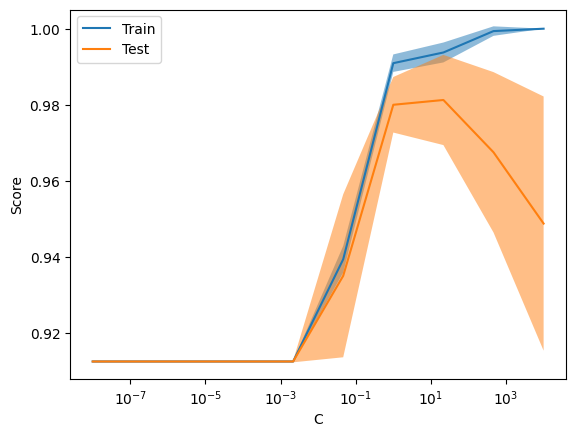

In [73]:
from sklearn.linear_model import LogisticRegression

ValidationCurveDisplay.from_estimator(
    LogisticRegression(solver="lbfgs", max_iter=2_000),
    X_preprocessed,
    y,
    param_name="C",
    param_range=np.logspace(-8, 4, 10),
)

In [76]:
model_lr = LogisticRegression(C=100, solver="lbfgs", max_iter=3_000, random_state=0)

scores = cross_val_score(model_lr, X_preprocessed, y, cv=5)
display(scores.mean())

0.9762888198757764

In [ ]:
from sklearn.ensemble import RandomForestClassifier

model_rf = RandomForestClassifier(n_estimators=500, n_jobs=-1, random_state=0)

scores = cross_val_score(model_rf, X_preprocessed, y, cv=5)
display(scores.mean())

0.99375

We overall get a good result with as expected a better score from the Random Forest Classifier which is generally more robust than linear models.

## Statistical analysis

There are various questions one can answer by analyzing the dataset. For instance:
> How does height and weight of a Pokemon correlate with its various base stats?

In [80]:
pokemon_df.columns

Index(['abilities', 'against_bug', 'against_dark', 'against_dragon',
       'against_electric', 'against_fairy', 'against_fight', 'against_fire',
       'against_flying', 'against_ghost', 'against_grass', 'against_ground',
       'against_ice', 'against_normal', 'against_poison', 'against_psychic',
       'against_rock', 'against_steel', 'against_water', 'attack',
       'base_egg_steps', 'base_happiness', 'base_total', 'capture_rate',
       'classfication', 'defense', 'experience_growth', 'height_m', 'hp',
       'japanese_name', 'name', 'percentage_male', 'pokedex_number',
       'sp_attack', 'sp_defense', 'speed', 'type1', 'type2', 'weight_kg',
       'generation', 'is_legendary'],
      dtype='object')

<Axes: xlabel='height_m', ylabel='weight_kg'>

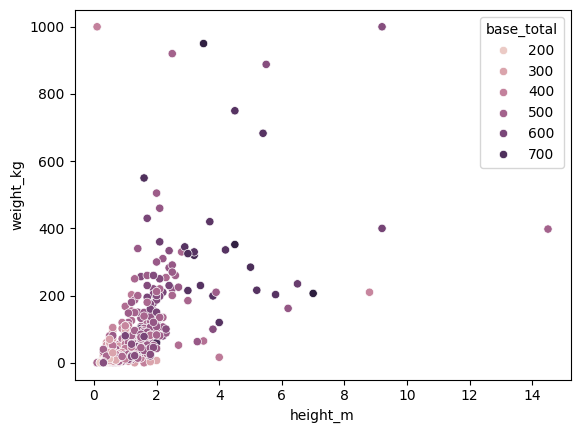

In [78]:
sns.scatterplot(pokemon_df, x="height_m", y="weight_kg", hue="base_total")

We see that these two variables make a sort of cone: as height and/or weight increase, so does the base total power.

Another question:
> Which type is the strongest overall? Which is the weakest?

In [81]:
my_order = pokemon_df.groupby(by=["type1"])["base_total"].median().sort_values(ascending=False).index

<Axes: xlabel='base_total', ylabel='type1'>

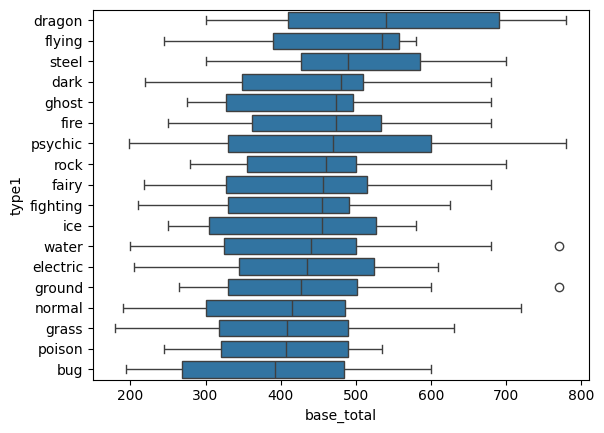

In [23]:
sns.boxplot(pokemon_df, y="type1", x="base_total", order=my_order)

We see the dragon type pokemons are the strongest although there is a wide spread of strength for them. Coming after are flying and steel pokemon. Note that this is probably due to the overlap with legendary pokemon!

In [24]:
pkmn_nolegendary_df = pokemon_df.loc[pokemon_df["is_legendary"] == 0]
my_order_no_legendary = (
    pkmn_nolegendary_df.groupby(by=["type1"])["base_total"].median().sort_values(ascending=False).index
)

<Axes: xlabel='base_total', ylabel='type1'>

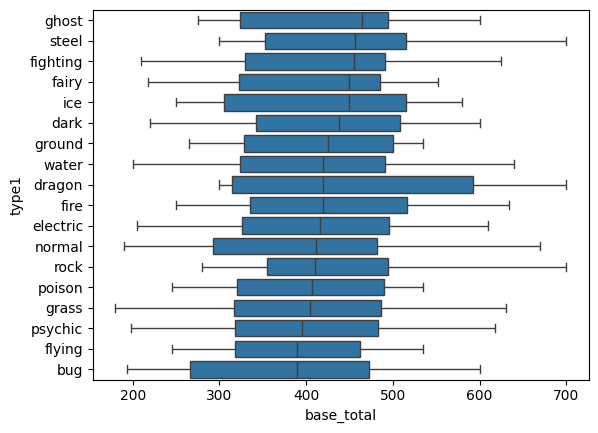

In [25]:
sns.boxplot(pkmn_nolegendary_df, y="type1", x="base_total", order=my_order_no_legendary)

After removing the legendary pokemon, we immediately see that dragons drop down severely, so do steel pokemons. Therefore when it comes to non-legendary pokemons, the best types are `ghost`, `steel`, `fighting`, `fairy` in terms of pure strenght.

Another important question we can answer is whether there is any connection between the pokedex number and the legendary status.

<Axes: xlabel='generation', ylabel='pokedex_number'>

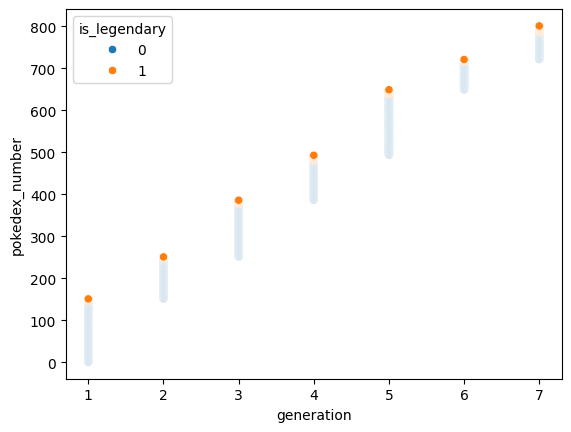

In [26]:
sns.scatterplot(pokemon_df, x="generation", y="pokedex_number", hue="is_legendary")

As expected, most legendaries are the end of the pokedex of their given generation! Let's see if we can make a feature for this.

In [27]:
all_generations = list(X["generation"].unique())
max_id_per_generations = [X.loc[X["generation"] == g, "pokedex_number"].max() for g in all_generations]

In [47]:
def get_ratio_number(row):
    id = row["pokedex_number"]
    gen_idx = row["generation"] - 1
    if gen_idx == 0:
        return id / max_id_per_generations[gen_idx]
    else:
        return (id - max_id_per_generations[gen_idx - 1]) / (
            max_id_per_generations[gen_idx] - max_id_per_generations[gen_idx - 1]
        )


X["pokedex_number_ratio"] = X.apply(get_ratio_number, axis=1)

<Axes: xlabel='generation', ylabel='pokedex_number_ratio'>

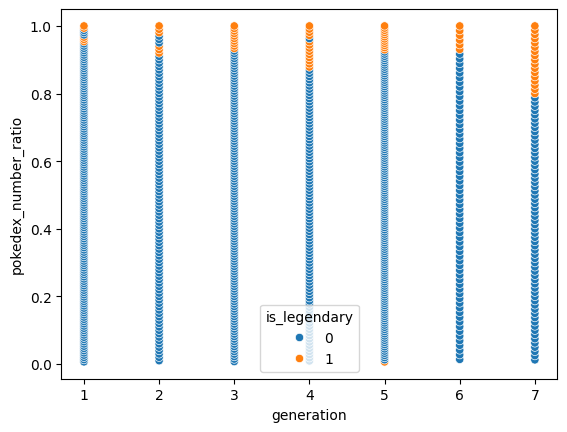

In [48]:
pkmn_merge_df = pd.concat([X, y], axis=1)
sns.scatterplot(pkmn_merge_df, x="generation", y="pokedex_number_ratio", hue="is_legendary")

We see our intuition was correct except for a few outliers. In generations 1, 2 and 4, there are a few pokemon between the legendary beasts and the box legendaries. The surprising outlier is Victini in Generation V who is at the beginning (formally #0) instead of being at the end.

In [49]:
X_preprocessed_2 = preprocessor_encoder.fit_transform(X)

In [50]:
model_rf_2_ = RandomForestClassifier(n_estimators=500, n_jobs=-1, random_state=0)

scores_2 = cross_val_score(model_rf_2_, X_preprocessed_2, y, cv=5)
display(scores_2.mean())

0.99125

In [53]:
diff_mean = (scores_2 - scores).mean()
diff_mean

0.0024922360248447405

Success! This new feature did bring "some" improvement on the model (although at 99% any improvement is marginal).